# AISHELL开源版 - 数据分析报告

In [ ]:
!pip install pypinyin

In [ ]:
import os
import glob
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import IPython.display as ipd
from tqdm import tqdm
from pypinyin import lazy_pinyin, Style

## 挂载 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 解压数据

数据来自：[AISHELL开源版 - 数据下载](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/AISHELL开源版/notebooks/AISHELL开源版-下载数据.ipynb)

In [ ]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/AISHELL开源版/data_aishell.tgz > unzip_log.txt

In [ ]:
for file in tqdm(glob.glob('/content/data_aishell/wav/*.tar.gz')):
  !tar -zxvf {file} -C /content/data_aishell >> unzip_single_log.txt

100%|██████████| 400/400 [06:11<00:00,  1.08it/s]


## 工具方法

查看音频

In [ ]:
# 这个要在执行完 `统计音频时长` 和 `统计句子长度` 之后才能运行
def show_audio(name):
  path = file_list[name]
  audio, sr = librosa.load(path, sr=None)
  text = sentences[name]
  print(''.join(text))
  ipd.display(ipd.Audio(audio, rate=sr))

## 统计音频时长

In [ ]:
# 音频文件列表
file_list = dict()

for file in glob.glob('/content/data_aishell/**/*.wav', recursive=True):
  name = os.path.splitext(os.path.split(file)[1])[0]
  file_list[name] = file

In [ ]:
audio_duration = dict()

for name, path in tqdm(list(file_list.items())):
  audio_duration[name] = librosa.get_duration(filename=path)

audio_duration = pd.DataFrame.from_dict(audio_duration, orient='index', columns=['duration'])
audio_duration = audio_duration.sort_values('duration', ascending=False)

100%|██████████| 141925/141925 [03:26<00:00, 686.30it/s]


总时长（小时）

In [ ]:
audio_duration.sum() / 3600

duration    179.377617
dtype: float64

总体特征

In [ ]:
audio_duration.describe()

,duration
count,141925.000000
mean,4.550005
std,1.376110
min,0.000000
25%,3.507062
50%,4.286000
75%,5.362813
max,14.699938


时长分布

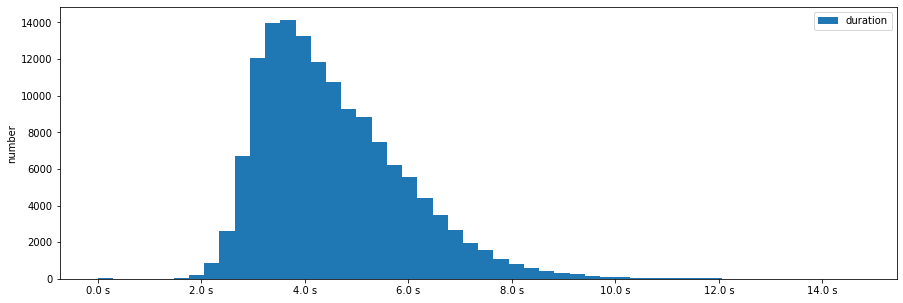

In [ ]:
audio_duration.plot.hist(bins=50, figsize=(15, 5))
plt.ylabel('number')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f s'))

最长的 5 条音频

In [ ]:
audio_duration.head()

,duration
BAC009S0768W0452,14.699938
BAC009S0658W0472,14.531250
BAC009S0212W0468,13.975812
BAC009S0906W0219,13.927000
BAC009S0708W0216,13.371000


## 统计句子长度

In [ ]:
sentences = dict()

with open('/content/data_aishell/transcript/aishell_transcript_v0.8.txt') as f:
  for line in f:
    # 编号的长度为16
    if len(line) > 16:
      name = line[:16]
      words = list(line[16:].strip().replace(' ', ''))
      sentences[name] = words

计算字数

In [ ]:
sentences_length = dict()
for k, v in sentences.items():
  sentences_length[k] = len(v)

sentences_length = pd.DataFrame.from_dict(sentences_length, orient='index', columns=['length'])
sentences_length = sentences_length.sort_values('length', ascending=False)

总字数

In [ ]:
sentences_length.sum()

length    2040219
dtype: int64

总体特征

In [ ]:
sentences_length.describe()

,length
count,141600.000000
mean,14.408326
std,4.309294
min,1.000000
25%,11.000000
50%,14.000000
75%,18.000000
max,44.000000


长度分布

Text(0, 0.5, 'number')

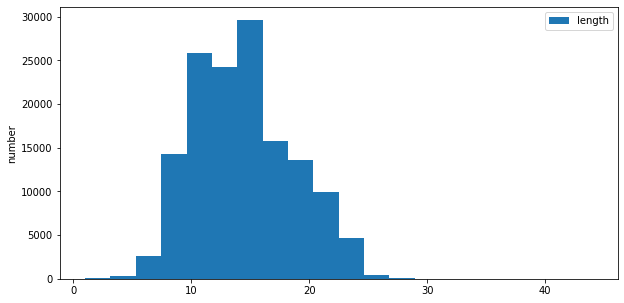

In [ ]:
sentences_length.plot.hist(bins=20, figsize=(10, 5))
plt.ylabel('number')

最长的 5 条句子

In [ ]:
sentences_length.head()

,length
BAC009S0107W0142,44
BAC009S0073W0126,39
BAC009S0657W0266,39
BAC009S0089W0364,38
BAC009S0915W0421,37


## 统计语速变化

In [ ]:
speed_change = pd.merge(audio_duration, sentences_length, left_index=True, right_index=True)
speed_change = speed_change['duration'] / speed_change['length'] * 1000
speed_change = pd.DataFrame(speed_change, columns=['speed (ms)'])
speed_change = speed_change.sort_values('speed (ms)', ascending=False)

总体特征

In [ ]:
speed_change.describe()

,speed (ms)
count,141600.000000
mean,320.784689
std,52.419231
min,178.350543
25%,285.400000
50%,313.818182
75%,347.626420
max,1650.125000


语速分布

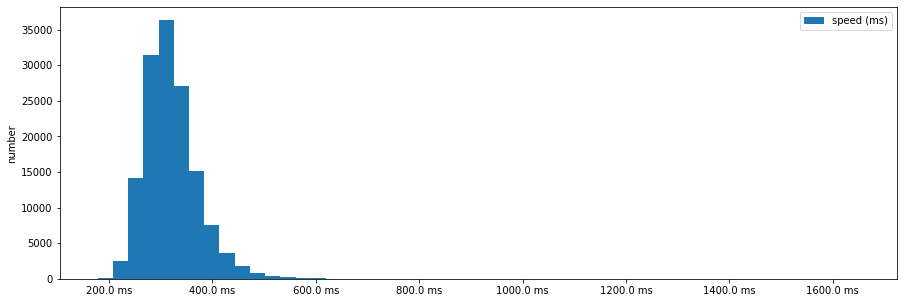

In [ ]:
speed_change.plot.hist(bins=50, figsize=(15, 5))
plt.ylabel('number')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f ms'))

语速最快的 5 条音频

In [ ]:
speed_change.tail().iloc[::-1]

,speed (ms)
BAC009S0904W0263,178.350543
BAC009S0135W0430,181.955357
BAC009S0904W0304,182.360795
BAC009S0135W0395,182.551136
BAC009S0124W0391,182.815476


语速最慢的 5 条音频

In [ ]:
# 都只有一个字
speed_change.head()

,speed (ms)
BAC009S0094W0364,1650.1250
BAC009S0094W0360,1605.9375
BAC009S0094W0361,1587.1875
BAC009S0094W0359,1551.0000
BAC009S0094W0362,1541.0000


## 统计发音覆盖范围

### 5 种声调的分布情况

In [ ]:
pinyin_distribution = dict()

for words in sentences.values():
  pinyins = lazy_pinyin(words, Style.TONE3, neutral_tone_with_five=True)
  for i in pinyins:
    if i in pinyin_distribution:
      pinyin_distribution[i] +=1 
    else:
      pinyin_distribution[i] = 1

pinyin_distribution = pd.DataFrame.from_dict(pinyin_distribution, orient='index', columns=['number'])
pinyin_distribution = pinyin_distribution.sort_values('number', ascending=False)

总体特征

In [ ]:
# 从结果来看，这个数据集并没有覆盖到所有的发音，一个使用4种声调的拼音表有1644种发音，而这里使用5种声调却只有1146种
pinyin_distribution.describe()

,number
count,1146.000000
mean,1780.295812
std,3662.474905
min,1.000000
25%,78.000000
50%,458.500000
75%,2006.500000
max,59022.000000


发音分布

Text(0, 0.5, 'number')

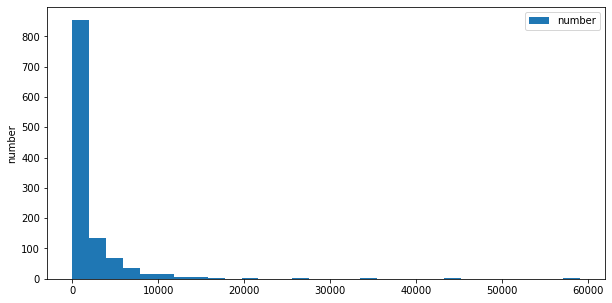

In [ ]:
pinyin_distribution.plot.hist(bins=30, figsize=(10, 5))
plt.ylabel('number')

出现次数前 5 的发音

In [ ]:
pinyin_distribution.head()

,number
de5,59022
shi4,45006
yi1,33665
shi2,27529
bu4,21339


### 去除声调后的分布情况

In [ ]:
pinyin_distribution_without_intonation = dict()

for words in sentences.values():
  pinyins = lazy_pinyin(words)
  for i in pinyins:
    if i in pinyin_distribution_without_intonation:
      pinyin_distribution_without_intonation[i] +=1 
    else:
      pinyin_distribution_without_intonation[i] = 1

pinyin_distribution_without_intonation = pd.DataFrame.from_dict(pinyin_distribution_without_intonation, orient='index', columns=['number'])
pinyin_distribution_without_intonation = pinyin_distribution_without_intonation.sort_values('number', ascending=False)

总体特征

In [ ]:
# 从结果来看，不带声调的发音覆盖的比较好，不带声调的拼音表有411种发音，这里有404种
pinyin_distribution_without_intonation.describe()

,number
count,404.000000
mean,5050.047030
std,7799.701044
min,1.000000
25%,606.000000
50%,2514.000000
75%,6667.750000
max,79789.000000


发音分布

Text(0, 0.5, 'number')

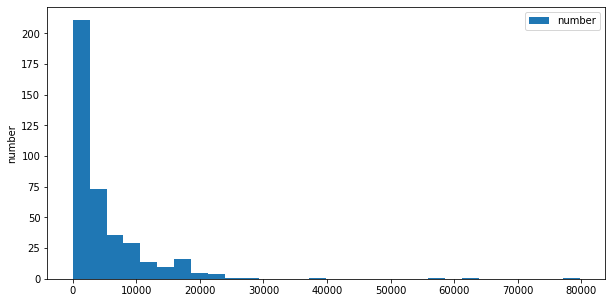

In [ ]:
pinyin_distribution_without_intonation.plot.hist(bins=30, figsize=(10, 5))
plt.ylabel('number')

出现次数前 5 的发音

In [ ]:
pinyin_distribution_without_intonation.head()

,number
shi,79789
de,63543
yi,56822
ji,38777
zhi,29249
